In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TemporalFusionTransformer import TemporalFusionTransformer

In [2]:
import torch.utils
import torch.utils.data


lookback = 30
future_steps = 40
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 16

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)


### Optional: shuffle the dataset

In [3]:
# import random
# random.shuffle(ds.dataset)

In [4]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data(future_steps=future_steps)

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)


feature_dim = ds.feature_dim
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'start_station_X', 'start_station_Y', 'end_station_X',
       'end_station_Y', 'distance_from_start_station_X',
       'distance_from_start_station_Y', 'distance_from_end_station_X',
       'distance_from_end_station_Y', 'facing_start_station',
       'facing_end_station', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'AGV_name',
       'looking_at_closest_station', 'rolling_avg'],
      dtype='object') 
feature_dim : 32


In [5]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([16, 30, 32]) torch.Size([16, 40, 32])
4127 459


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

model = TemporalFusionTransformer(num_features=feature_dim, 
                                  num_hidden=128, num_outputs=2, 
                                  num_steps=future_steps)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)


model.to(device)


Using cuda


TemporalFusionTransformer(
  (encoder_grn): GatedResidualNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=32, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=128, bias=True)
  )
  (transformer_block): TransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (feed_forward): Sequential(
      (0): Linear(in_features=128, 

### Customized Loss Function

In [12]:

class DecayLoss(nn.Module):
    def __init__(self, num_steps, baseline_loss_fn=nn.L1Loss()):
        super(DecayLoss, self).__init__()
        # Weight decreases as we move further into the future
        self.weights = torch.linspace(1.0, 1.0, num_steps)
        self.baseline_loss_fn = baseline_loss_fn
        

    def forward(self, predictions, targets):
        loss = 0
        for i in range(predictions.shape[1]):
            loss += self.weights[i] * self.baseline_loss_fn(predictions[:, i], targets[:, i])
        return loss
    
baseline_loss_fn = nn.L1Loss() #nn.MSELoss()
loss_fn = DecayLoss(future_steps, baseline_loss_fn=baseline_loss_fn)

### Trainer with early stop

In [14]:

# Parameters
n_epochs = 10
eval_step = 500
save_every = 10000
patience = 15  # Number of evaluations to wait for improvement
cooldown = 6  # Evaluations to wait after an improvement before counting non-improvements
smooth_factor = 0.6  # Smoothing factor for moving average

# Setup
train_all = len(train)
model_name = "TFT"
loss_all = []
best_test_rmse = float('inf')
early_stopping_counter = 0
cooldown_counter = cooldown

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
print(f"Saving model at ../model/{model_name}/{folder_name}")

# Initialize moving average
moving_avg_test_rmse = None

# Training loop
for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total=train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        
        current_pos_input = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_batch[:, :, :2] = X_batch[:, :, :2] - current_pos_input
        y_batch[:, :, :2] = y_batch[:, :, :2] - current_pos_output
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        loss_all.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Save model
        if (epoch * train_all + step + 1) % save_every == 0:
            save_path = f"../model/{model_name}/{folder_name}/model_{epoch * train_all + step + 1}.pt"
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

        # Validation and early stopping
        if (epoch * train_all + step + 1) % eval_step == 0:
            model.eval()
            test_rmse_all = []
            with torch.no_grad():
                for X_test_batch, y_test_batch in test:
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    
                    current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
                    current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
                    X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
                    y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
                    
                    y_pred_test = model(X_test_batch)
                    loss_test = loss_fn(y_pred_test[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss_test)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())
            
            current_rmse = sum(test_rmse_all) / len(test_rmse_all)
            if moving_avg_test_rmse is None:
                moving_avg_test_rmse = current_rmse
            else:
                moving_avg_test_rmse = smooth_factor * current_rmse + (1 - smooth_factor) * moving_avg_test_rmse

            print(f"Steps {epoch * train_all + step + 1}: test RMSE {current_rmse:.4f}, moving average RMSE {moving_avg_test_rmse:.4f}")

            # Check if the moving average RMSE is better; if not, increment counter
            if moving_avg_test_rmse < best_test_rmse:
                best_test_rmse = moving_avg_test_rmse
                early_stopping_counter = 0  # Reset counter
                cooldown_counter = cooldown  # Reset cooldown
                # Optionally save the best model
                best_model_path = f"../model/{model_name}/{folder_name}/best_model.pt"
                torch.save(model.state_dict(), best_model_path)
            else:
                if cooldown_counter > 0:
                    cooldown_counter -= 1
                else:
                    early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}, step {step+1}")
                break

            model.train()
        
    if early_stopping_counter >= patience:
        break

print("Training complete.")

Saving model at ../model/TFT/Aug02_14-35-47


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 500: test RMSE 0.8687, moving average RMSE 0.8687
Steps 1000: test RMSE 0.7862, moving average RMSE 0.8192
Steps 1500: test RMSE 0.7493, moving average RMSE 0.7773
Steps 2000: test RMSE 0.7362, moving average RMSE 0.7526
Steps 2500: test RMSE 0.7015, moving average RMSE 0.7220
Steps 3000: test RMSE 0.6946, moving average RMSE 0.7056
Steps 3500: test RMSE 0.7011, moving average RMSE 0.7029
Steps 4000: test RMSE 0.7215, moving average RMSE 0.7141


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 4500: test RMSE 0.6759, moving average RMSE 0.6912
Steps 5000: test RMSE 0.6745, moving average RMSE 0.6811
Steps 5500: test RMSE 0.6738, moving average RMSE 0.6767
Steps 6000: test RMSE 0.6867, moving average RMSE 0.6827
Steps 6500: test RMSE 0.6943, moving average RMSE 0.6897
Steps 7000: test RMSE 0.6660, moving average RMSE 0.6755
Steps 7500: test RMSE 0.6532, moving average RMSE 0.6621
Steps 8000: test RMSE 0.6889, moving average RMSE 0.6782


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 8500: test RMSE 0.6663, moving average RMSE 0.6710
Steps 9000: test RMSE 0.6678, moving average RMSE 0.6691
Steps 9500: test RMSE 0.6900, moving average RMSE 0.6816
Model saved at ../model/TFT/Aug02_14-35-47/model_10000.pt
Steps 10000: test RMSE 0.6883, moving average RMSE 0.6856
Steps 10500: test RMSE 0.6775, moving average RMSE 0.6808
Steps 11000: test RMSE 0.6670, moving average RMSE 0.6725
Steps 11500: test RMSE 0.6613, moving average RMSE 0.6658
Steps 12000: test RMSE 0.6998, moving average RMSE 0.6862


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 12500: test RMSE 0.6822, moving average RMSE 0.6838
Steps 13000: test RMSE 0.6684, moving average RMSE 0.6746
Steps 13500: test RMSE 0.6634, moving average RMSE 0.6679
Steps 14000: test RMSE 0.6597, moving average RMSE 0.6630
Steps 14500: test RMSE 0.6703, moving average RMSE 0.6674
Steps 15000: test RMSE 0.6502, moving average RMSE 0.6571
Steps 15500: test RMSE 0.6754, moving average RMSE 0.6681
Steps 16000: test RMSE 0.6668, moving average RMSE 0.6673
Steps 16500: test RMSE 0.6695, moving average RMSE 0.6686


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 17000: test RMSE 0.6615, moving average RMSE 0.6644
Steps 17500: test RMSE 0.6781, moving average RMSE 0.6726
Steps 18000: test RMSE 0.6624, moving average RMSE 0.6665
Steps 18500: test RMSE 0.6696, moving average RMSE 0.6683
Steps 19000: test RMSE 0.6647, moving average RMSE 0.6661
Steps 19500: test RMSE 0.6587, moving average RMSE 0.6617
Model saved at ../model/TFT/Aug02_14-35-47/model_20000.pt
Steps 20000: test RMSE 0.6751, moving average RMSE 0.6697
Steps 20500: test RMSE 0.6735, moving average RMSE 0.6720


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 21000: test RMSE 0.6696, moving average RMSE 0.6705
Steps 21500: test RMSE 0.6620, moving average RMSE 0.6654
Steps 22000: test RMSE 0.6656, moving average RMSE 0.6655
Steps 22500: test RMSE 0.6914, moving average RMSE 0.6811
Steps 23000: test RMSE 0.6707, moving average RMSE 0.6748
Steps 23500: test RMSE 0.6755, moving average RMSE 0.6753
Steps 24000: test RMSE 0.6725, moving average RMSE 0.6736
Steps 24500: test RMSE 0.6768, moving average RMSE 0.6755


  0%|          | 0/4127 [00:00<?, ?it/s]

Steps 25000: test RMSE 0.6625, moving average RMSE 0.6677
Steps 25500: test RMSE 0.6842, moving average RMSE 0.6776
Stopping early at epoch 7, step 738
Training complete.


In [15]:
validation_step = future_steps

predictions = []
truths = []

with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        
        current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
        y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
        
        y_pred = model(X_test_batch)
        predictions.append(y_pred[:, :validation_step, :2] + current_pos_output)
        truths.append(y_test_batch[:, :validation_step, :2] + current_pos_output)
        
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/459 [00:00<?, ?it/s]

In [16]:
# reverse normalization
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

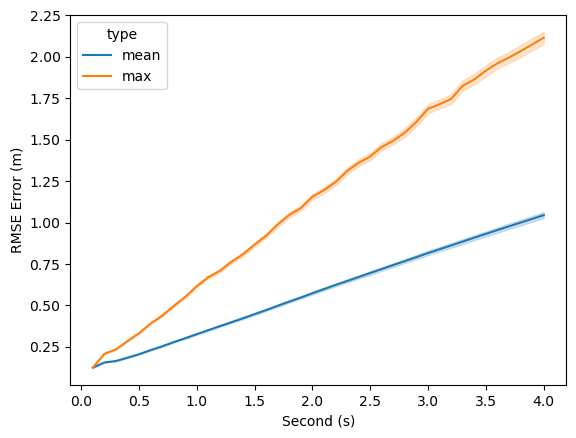

In [17]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, future_steps+1):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type',) #  errorbar=('sd', 1),
# plt.savefig('../figure/TFT_manual_shuffle_relative.png')
plt.show()

In [39]:
df.groupby(by=['Second (s)', 'type']).mean().unstack()['RMSE Error (m)'].tail(10)

type,max,mean
Second (s),,
3.1,1.714044,0.839101
3.2,1.746317,0.861844
3.3,1.825872,0.885482
3.4,1.863867,0.908474
3.5,1.916832,0.931688
3.6,1.961002,0.954706
3.7,1.995483,0.977107
3.8,2.034418,0.999497
3.9,2.074492,1.021814


### Export JIT Model

In [ ]:
EXPORT_MODEL = False

# model.load_state_dict(torch.load("/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/model/Jul09_20-37-37/model_40000.pt"))
if EXPORT_MODEL:
    model.eval()
    script_module = torch.jit.script(model)
    os.makedirs(f'../model/exported/', exist_ok=True)
    script_module.save(f"../exported/model.pt")

### Save data (for interactive visualization)

In [122]:
# model = torch.jit.load('../exported/model.pt')

test_ds = MyDataset(lookback=lookback)
all_ds = ds.dataset
test_ds.dataset = all_ds[len(all_ds)//10 :] # load the last 10% of the data
X_list, y_list = test_ds.generate_data(return_list=True, future_steps=future_steps)


In [123]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

normalize_dict = stats_dict
pred_data = []
truth_data = []
input_data = []
model.eval()

for i, (X, y) in enumerate(zip(X_list, y_list)):
    current_pos_input = X[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
    current_pos_output = X[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1).to(device)
    X[:, :, :2] = X[:, :, :2] - current_pos_input

    predictions = model(X.float().to(device))[:, :future_steps, :2]
    predictions = predictions + current_pos_output
    predictions = predictions.to('cpu')
    
    truths = y[:, :future_steps, :2]
    X[:, :, :2] = X[:, :, :2] + current_pos_input
    model_input = X.float().to(device)[:, :lookback, :2]
    trajectory_id = i
    
    # reverse normalization
    for idx, key_ in enumerate(["User_X", "User_Y"]):
        predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
        predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
        truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
        truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
        model_input[:, :, idx] = model_input[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
        model_input[:, :, idx] = model_input[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    
    for group_id in range(predictions.shape[0]):
        for time_step in range(predictions.shape[1]):
            pred_x, pred_y = predictions[group_id, time_step]
            pred_data.append([trajectory_id, group_id, time_step, pred_x.item(), pred_y.item()])

            truth_x, truth_y = truths[group_id, time_step]
            truth_data.append([trajectory_id, group_id, time_step, truth_x.item(), truth_y.item()])
        
        for time_step in range(lookback):
            input_x, input_y = model_input[group_id, time_step]
            input_data.append([trajectory_id, group_id, time_step, input_x.item(), input_y.item()])
            

pred_df = pd.DataFrame(pred_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
truth_df = pd.DataFrame(truth_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
input_df = pd.DataFrame(input_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])


In [124]:
files_to_remove = [
    "../data/pred_tra_all.pkl",
    "../data/truth_tra_all.pkl", 
    "../data/input_tra_all.pkl"
]

for file_path in files_to_remove:
    if os.path.exists(file_path):
        os.remove(file_path)

truth_df.to_pickle("../data/truth_tra_all.pkl")
pred_df.to_pickle("../data/pred_tra_all.pkl")
input_df.to_pickle("../data/input_tra_all.pkl")